## Import the Modules

In [10]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import winsound
import time
import face_recognition
from scipy.spatial import distance
warnings.filterwarnings('ignore')

## Highlight facial points in the image

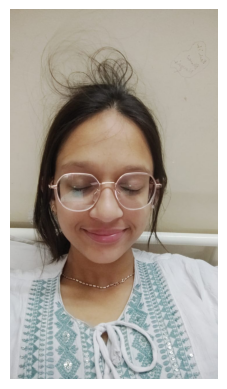

In [11]:
image_path = 'test1.jpg'
image = Image.open(image_path)
plt.axis('off')
plt.imshow(image)
plt.show()

In [12]:
def highlight_facial_points(image_path):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image_rgb, model='cnn')
    for face_location in face_locations:
        landmarks = face_recognition.face_landmarks(image_rgb, [face_location])[0]
        for landmark_type, landmark_points in landmarks.items():
            for(x,y) in landmark_points:
                cv2.circle(image_rgb, (x,y), 3, (0,255,0), -1)

    plt.figure(figsize=(6,6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

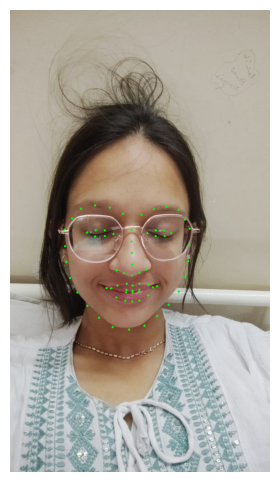

In [13]:
highlight_facial_points(image_path)

In [5]:
def eye_aspect_ratio(eye):
    a = distance.euclidean(eye[1],eye[5])
    b = distance.euclidean(eye[2],eye[4])
    c = distance.euclidean(eye[0],eye[3])
    eye_aspect_ratio = (a+b)/(2.0*c)
    return eye_aspect_ratio

In [6]:
def mouth_aspect_ratio(mouth):
    a = distance.euclidean(mouth[2],mouth[10])
    b = distance.euclidean(mouth[4],mouth[8])
    c = distance.euclidean(mouth[0],mouth[6])
    mouth_aspect_ratio = (a+b)/(2.0*c)
    return mouth_aspect_ratio

In [7]:
def process_image(frame):
    eye_AR_thresh = 0.25
    mouth_AR_thresh = 0.6
    if frame is None:
        raise ValueError("Image not found or Unable to open")
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb_frame)
    eye_flag = mouth_flag = False
    for face_location in face_locations:
        landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
        left_eye = np.array(landmarks['left_eye'])
        right_eye = np.array(landmarks['right_eye'])
        mouth = np.array(landmarks['bottom_lip'])
        left_eye_AR = eye_aspect_ratio(left_eye)
        right_eye_AR = eye_aspect_ratio(right_eye)
        ear = (left_eye_AR * right_eye_AR) / 2.0
        mar = mouth_aspect_ratio(mouth)
        if mar<eye_AR_thresh:
            eye_flag = True
        if mar>mouth_AR_thresh:
            mouth_flag = True

    return eye_flag, mouth_flag

In [8]:
img = cv2.imread(image_path)
process_image(img)

(True, False)

## Real Time Drowsiness Detection

In [14]:
video_cap = cv2.VideoCapture(0)
count = score = 0
drowsy_alert_triggered = False
last_alert_time = 0 

while True:
    success, image = video_cap.read()
    if not success:
        break

    image = cv2.resize(image, (800, 500))
    count += 1
    n = 5 

    if count % n == 0:
        eye_flag, mouth_flag = process_image(image)

        if eye_flag or mouth_flag:  
            score += 1
        else:  
            score -= 2  
            if score < 0:
                score = 0

    font = cv2.FONT_HERSHEY_SIMPLEX
    text_x, text_y = 10, image.shape[0] - 10
    text = f"Score: {score}"
    cv2.putText(image, text, (text_x, text_y), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    if score >= 5:
        text_x, text_y = image.shape[1] - 130, 40
        cv2.putText(image, "Drowsy", (text_x, text_y), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

        if time.time() - last_alert_time > 5:  
            winsound.Beep(1000, 500)
            last_alert_time = time.time()  

    if score < 5:
        drowsy_alert_triggered = False

    cv2.imshow('Drowsiness Detection', image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_cap.release()
cv2.destroyAllWindows()